по терминологии: чтобы не возникло путаницы в понятии вершины, я буду называть вершину графа вертексом, а вершину в синтаксическом дереве вершиной
а ребро графа либо ребром, либо эджом. чанк - это именная группа

In [2]:
import spacy
import spacy.cli
from graph.graph import Graph, visualize_graph
from graph.edge import Edge
from graph.vertex import Vertex
from spacy import displacy

In [9]:
spacy.cli.download("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 571.0 kB/s eta 0:00:0000:0100:27
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
def find_nearest_vertex(token, chunk_to_vertex):
    """
    Ищет ближайшую вершину для токена, поднимаясь вверх по дереву зависимостей.
    """
    visited = set()
    while token and token not in chunk_to_vertex:
        if token in visited or token.head == token:
            return None  # Защита от бесконечного цикла
        visited.add(token)
        token = token.head  # Поднимаемся выше в дереве
    return chunk_to_vertex.get(token)

In [4]:
def process_token(token, graph, chunk_to_vertex):
    """
    Обрабатывает токен, добавляя рёбра между существующими вершинами (именными группами).
    """
    for child in token.children:
        head_vertex = find_nearest_vertex(token, chunk_to_vertex)
        child_vertex = find_nearest_vertex(child, chunk_to_vertex)
        
        print(f"Checking edge: {token.text} -> {child.text}")
        print(f"Head vertex: {head_vertex}, Child vertex: {child_vertex}")
        
        if head_vertex and child_vertex and token.pos_ == "ADP":  # Обрабатываем только предлоги
            edge_tuple = (head_vertex.concept, child_vertex.concept, token.text)
            
            # Проверяем, есть ли уже такое ребро
            if edge_tuple not in {(e.agent_1, e.agent_2, e.meaning) for e in graph.edges}:
                print(f"Adding edge: {head_vertex.concept} --[{token.text}]--> {child_vertex.concept}")
                graph.add_edge(head_vertex.concept, child_vertex.concept, token.text, 1, 0)
        
        process_token(child, graph, chunk_to_vertex)

In [5]:
def build_graph_from_parse_tree(doc) -> Graph:
    """
    Строит граф, где вершины - только именные группы (noun chunks),
    а рёбра - только предлоги.
    """
    graph = Graph()
    chunk_to_vertex = {}
    
    # Добавляем вершины только для именных групп (исключаем глаголы и наречия)
    for chunk in doc.noun_chunks:
        vertex = Vertex(chunk.text, [chunk.text])
        graph.add_vertex(vertex.concept, vertex.words_of_concept)
        chunk_to_vertex[chunk.root] = vertex  # Привязываем root токен к вершине
    
    # Добавляем рёбра между существующими вершинами
    for token in doc:
        if token.pos_ == "ADP":  # Обрабатываем только предлоги
            print(f"Processing token: {token.text} ({token.pos_})")
            process_token(token, graph, chunk_to_vertex)
    
    return graph

In [7]:
nlp_en = spacy.load("en_core_web_lg")

Processing token: under (ADP)
Checking edge: under -> tree
Head vertex: Vertex(concept='The elephant', words=['The elephant']), Child vertex: Vertex(concept='the tree', words=['the tree'])
Adding edge: The elephant --[under]--> the tree
Checking edge: tree -> the
Head vertex: Vertex(concept='the tree', words=['the tree']), Child vertex: Vertex(concept='the tree', words=['the tree'])
Vertices: {'The elephant': Vertex(concept='The elephant', words=['The elephant']), 'the tree': Vertex(concept='the tree', words=['the tree'])}
Edges: [Edge(The elephant <--[under]--> the tree)]


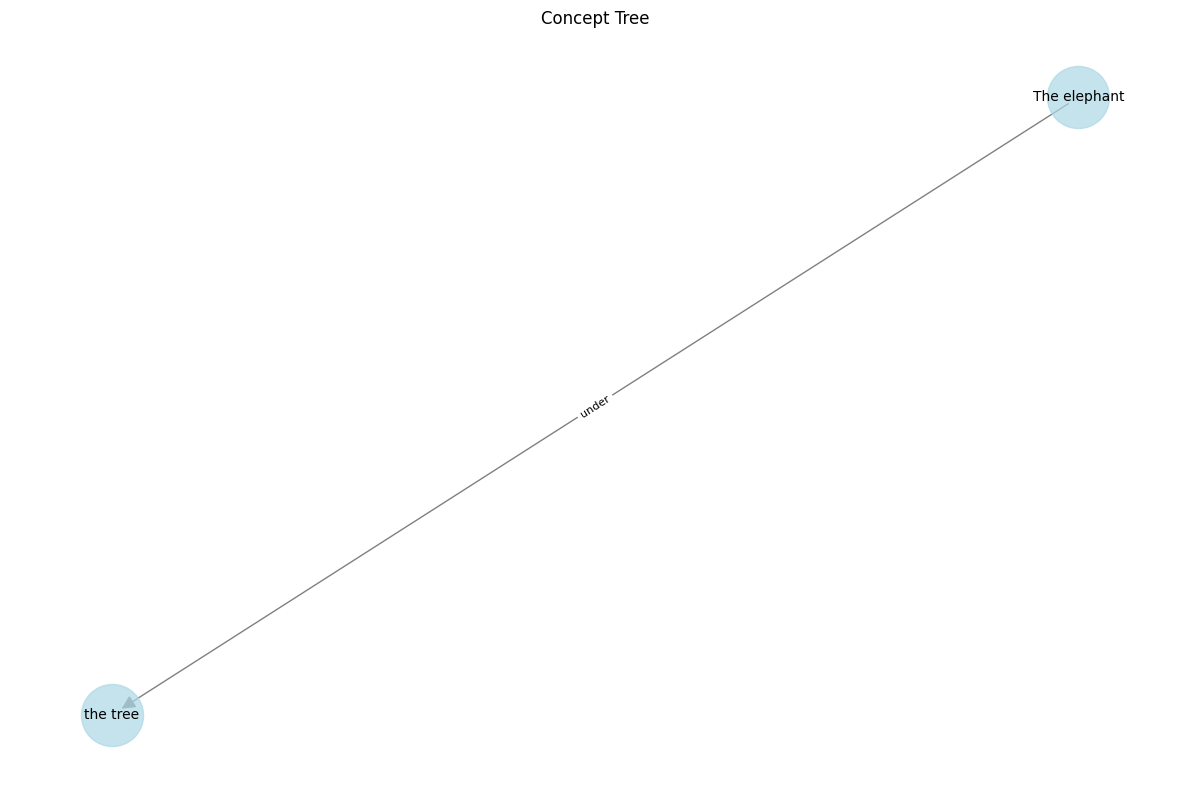

In [10]:
text = "The elephant under the tree"
doc = nlp_en(text)
syntax_graph = build_graph_from_parse_tree(doc)
print("Vertices:", syntax_graph.vertices)
print("Edges:", syntax_graph.edges)
visualize_graph(syntax_graph)

In [65]:
displacy.render(doc, style='dep')